In [5]:
!pip install earthengine-api rasterio albumentations tqdm

import os
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.9.0+cu128
CUDA available: True


# STEP 3 — Authenticate Google Earth Engine (Cell 2)

In [12]:
import ee

ee.Authenticate()

ee.Initialize(project="ndvi-trend-481019")  # use EXACT project ID

print("✅ GEE Initialized Successfully")


✅ GEE Initialized Successfully


# STEP 4 — Download Sentinel-2 Sample Data (Cell 3)

In [21]:
import ee
import requests
import rasterio
import numpy as np

# Define region
roi = ee.Geometry.Rectangle([82.40, 22.80, 82.45, 22.85])

# Get image
image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2022-01-01', '2022-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .first()
)

bands = image.select([
    'B2','B3','B4','B5','B6',
    'B7','B8','B8A','B11','B12'
])

url = bands.getDownloadURL({
    'region': roi,
    'scale': 20,
    'format': 'GEO_TIFF'
})

response = requests.get(url)

with open("sentinel_patch.tif", "wb") as f:
    f.write(response.content)

# Load properly
with rasterio.open("sentinel_patch.tif") as src:
    arr = src.read()

# Convert (bands, H, W) → (H, W, bands)
arr = np.transpose(arr, (1, 2, 0))

print("Shape:", arr.shape)


Shape: (280, 260, 10)


# STEP 5 — Add NDVI / EVI / SAVI / BSI (Cell 4)

In [27]:
def compute_indices(arr):
    B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12 = [arr[:,:,i] for i in range(10)]

    NDVI = (B8 - B4) / (B8 + B4 + 1e-6)
    EVI  = 2.5 * (B8 - B4) / (B8 + 6*B4 - 7.5*B2 + 1)
    SAVI = ((B8 - B4) / (B8 + B4 + 0.5)) * 1.5
    BSI  = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-6)

    return np.stack([NDVI,EVI,SAVI,BSI], axis=-1)

indices = compute_indices(arr)

full = np.concatenate([arr, indices], axis=-1)

print("Final shape with indices:", full.shape)
print(arr.ndim)
print("Image shape:", full.shape)


Final shape with indices: (280, 260, 14)
3
Image shape: (280, 260, 14)


# STEP 6 — Patch Extraction (Cell 5)

In [28]:
PATCH = 64
STRIDE = 32

def extract_patches(data, patch_size=PATCH, stride=STRIDE):
    H, W, C = data.shape
    patches = []

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = data[y:y+patch_size, x:x+patch_size, :]
            patches.append(patch)

    return patches

dataset = extract_patches(full)

print("Total patches:", len(dataset))


Total patches: 49


# STEP 7 — Augmentation (Cell 6)

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

# Convert numpy patches to tensor list
patches = dataset

class UrbanDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x = self.patches[idx]

        # Convert (H,W,C) → (C,H,W)
        x = torch.tensor(x, dtype=torch.float32).permute(2,0,1)

        # 🔥 TEMP synthetic labels (replace later with real masks)
        y = torch.randint(0, 5, (64,64))

        return x, y

train_dataset = UrbanDataset(patches)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print("Dataset ready:", len(train_dataset))


Dataset ready: 49


# STEP 8 — U-Net Model (Cell 7)


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=14, n_cls=5):
        super().__init__()

        self.inc = DoubleConv(in_ch, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, n_cls, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)

        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)

print("Model ready on:", device)


Model ready on: cuda


# STEP 9 — Dummy Training (Cell 8)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5  Loss: 1.6339
Epoch 2/5  Loss: 1.6119
Epoch 3/5  Loss: 1.6104
Epoch 4/5  Loss: 1.6100
Epoch 5/5  Loss: 1.6098


# STEP 10 — Visualization (Cell 9)

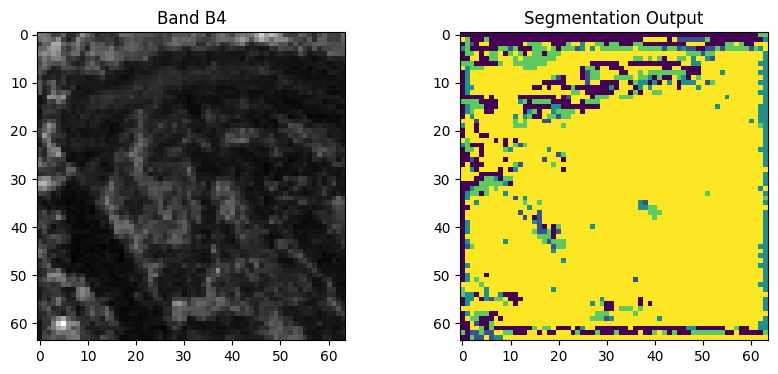

In [32]:
import matplotlib.pyplot as plt

model.eval()

x, y = next(iter(train_loader))
x = x.to(device)

with torch.no_grad():
    pred = model(x).argmax(1).cpu()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(x[0,2].cpu(), cmap='gray')
plt.title("Band B4")

plt.subplot(1,2,2)
plt.imshow(pred[0])
plt.title("Segmentation Output")

plt.show()


# Save Model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(),
           "/content/drive/MyDrive/urban_tree_unet.pth")


In [ ]:
######################################